# Learning to Transduce with Unbounded Memory

WIP


###References
http://arxiv.org/pdf/1506.02516.pdf


# Copy Problem

Working with keras 1.0

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import print_function
import logging
import numpy as np
np.random.seed(124)
import matplotlib
matplotlib.use("Pdf")
import matplotlib.pyplot as plt
import cPickle

from theano import tensor, function
import theano

from keras.datasets import mnist#theano.config.mode="FAST_COMPILE"

from keras.models import Graph, Sequential
from keras.layers import TimeDistributed, Dense, Dropout, Activation, Flatten, Masking
from keras.layers.recurrent import LSTM
from keras.utils import np_utils, generic_utils
from keras.optimizers import Adam, SGD
from keras import backend as K

from seya.layers.ntm import NeuralTuringMachine as NTM
from seya.layers.stack import Stack


#from seya.models import Sequential  # this is just good old Sequential, from before TensorFlow support

#from IPython import display

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
Using gpu device 0: Tesla K20Xm (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5004)
Using Theano backend.


In [2]:
batch_size = 100

h_dim = 128
n_slots = 50
m_length = 20
input_dim = 8
lr = 1e-3
clipnorm = 10
rnn_size= 128

In [3]:
# Neural Turing Machine

def load_model(model):
    
    if model == "NTM":
        h_dim=64
        ntm = NTM(h_dim, n_slots=n_slots, m_length=m_length, shift_range=3,
          inner_rnn='lstm', return_sequences=True, input_dim=input_dim)
    
    if model == "QUEUE":
        h_dim=128
        ntm = Stack(h_dim, n_slots=n_slots, m_length=m_length,
            inner_rnn='lstm', rnn_size=rnn_size,return_sequences=True, input_dim=input_dim,stack=False)
        
    if model == "STACK":
        h_dim = 128
        ntm = Stack(h_dim, n_slots=n_slots, m_length=m_length,
                  inner_rnn='lstm', rnn_size=rnn_size,return_sequences=True, input_dim=input_dim,stack=True)

    if model == "LSTM":
        h_dim=256
        ntm = LSTM(h_dim,return_sequences = True,input_dim = input_dim)
        
    model = Sequential()
    # model.add(Masking(input_shape=(None, input_dim)))
    model.add(ntm)
    model.add(TimeDistributed(Dense(input_dim)))
    model.add(Activation('sigmoid'))
    
    sgd = Adam(lr=lr, clipnorm=clipnorm)
    model.compile(loss='binary_crossentropy', optimizer=sgd, sample_weight_mode="temporal")
    
    return model

# Dataset

In [4]:
def get_sample(batch_size=128, n_bits=8, max_size=20, min_size=1):
    # generate samples with random length
    inp = np.zeros((batch_size, 2*max_size-1, n_bits))
    out = np.zeros((batch_size, 2*max_size-1, n_bits))
    sw = np.zeros((batch_size, 2*max_size-1, 1))
    for i in range(batch_size):
        t = np.random.randint(low=min_size, high=max_size)
        x = np.random.uniform(size=(t, n_bits)) > .5
        for j,f in enumerate(x.sum(axis=-1)): # remove fake flags
            if f>=n_bits:
                x[j, :] = 0.
        del_flag = np.ones((1, n_bits))
        inp[i, :t+1] = np.concatenate([x, del_flag], axis=0)
        out[i, t:(2*t)] = x
        sw[i, t:(2*t)] = 1
        #sw[i, t:(2*t)+2] = 1
    return inp, out, sw

In [5]:
def show_pattern(inp, out, sw, file_name='pattern2.png'):
    plt.figure(figsize=(10, 10))
    plt.subplot(131)
    plt.imshow(inp>.5)
    plt.subplot(132)
    plt.imshow(out>.5)
    plt.subplot(133)
    plt.imshow(sw[:, :1]>.5)
    plt.savefig(file_name)
    plt.close()

inp, out, sw = get_sample()
show_pattern(inp[0], out[0], sw[0])

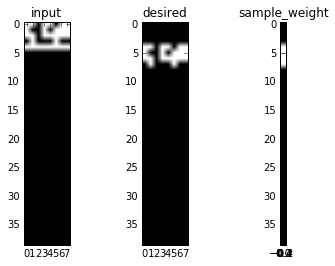

In [6]:
inp, out, sw = get_sample(1, 8, 20)

plt.subplot(131)
plt.title('input')
plt.imshow(inp[0], cmap='gray')
plt.subplot(132)
plt.title('desired')
plt.imshow(out[0], cmap='gray')
plt.subplot(133)
plt.title('sample_weight')
plt.imshow(sw[0], cmap='gray')

# sample_weight marks the points in time that will 
# be part of the cost function.

In [7]:
# training uses sequences of length 1 to 20. Test uses series of length 100.
def test_model(model, file_name, min_size=40,restrict=False):
    I, V, sw = get_sample(batch_size=500, n_bits=input_dim, max_size=min_size+1, min_size=min_size)
    Y = np.asarray(model.predict(I, batch_size=100) > .5).astype('float64')
    acc = (V[:, -min_size:, :] == Y[:, -min_size:, :]).mean() * 100
    if restrict:
        acc = np.average(V[:, -min_size:, :] == Y[:, -min_size:, :],
                          weights=np.repeat(sw[:,-min_size:,:],8,axis=2)) * 100
    show_pattern(Y[0], V[0], sw[0], file_name)

    return acc

In [8]:
results = {}
for model in ["STACK","QUEUE","LSTM","NTM"]:
    print(model)
    trained = load_model(model)
    nb_epoch = 4000
    progbar = generic_utils.Progbar(nb_epoch)
    ACC = []
    LOSS = []
    for e in range(nb_epoch):
        I, V, sw = get_sample(n_bits=input_dim, max_size=19, min_size=1, batch_size=100)
        #print(I.shape)
        
        #print(V.shape)
        loss = trained.train_on_batch(I, V, sample_weight=sw[:, :, 0])
        # loss = trained.fit(I, V, sample_weight=sw[:, :, 0], nb_epoch=1, batch_size=100, verbose=0).totals['loss']

        progbar.add(1, values=[("loss", loss)])
       

        if e % 100 == 0:
            
            acc = test_model(trained, 'ntm_test.png',min_size=19,restrict=True)
            l = []
            if e %1000 == 0:
                print("")
                for a in [acc,]:
                    print("acc: {}".format(a))
            for a in [acc,]:
                l.append(a)
            ACC.append(l)
            LOSS.append(loss)
            
    results[model] = [LOSS,ACC]
    


STACK
   1/4000 [..............................] - ETA: 163486s - loss: 0.6932
acc: 50.3875
1001/4000 [======>.......................] - ETA: 450s - loss: 0.5486
acc: 69.1597222222
2001/4000 [==============>...............] - ETA: 257s - loss: 0.4222
acc: 77.5833333333
3001/4000 [=====================>........] - ETA: 121s - loss: 0.3489
acc: 79.9444444444
4000/4000 [==============================] - 472s - loss: 0.3012   
QUEUE
   1/4000 [..............................] - ETA: 151696s - loss: 0.6933
acc: 49.8069444444
1001/4000 [======>.......................] - ETA: 436s - loss: 0.2185
acc: 99.9486111111
2001/4000 [==============>...............] - ETA: 250s - loss: 0.1398
acc: 99.9708333333
3001/4000 [=====================>........] - ETA: 118s - loss: 0.1058
acc: 99.9736111111
4000/4000 [==============================] - 462s - loss: 0.0815   
LSTM
   1/4000 [..............................] - ETA: 56995s - loss: 0.6970
acc: 50.3597222222
1001/4000 [======>.......................] -

##Comment on the results
There is a jump from classical learning curve to a 100 % of accuracy for the NTM and the queue. (cf next picture).

The time at which it takes place is a little bit random, and for some weight initialisation
it takes more time

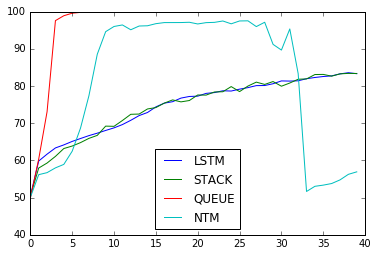

In [10]:
for model in ["LSTM","STACK","QUEUE","NTM"]:
    plt.plot(results[model][1],label=model)
plt.legend(loc="best")

# Comparison python theano implementation of stack

In [ ]:
def python_stack(V_tm1,s_tm1,d,u,v,time):
    V_t = V_tm1
    V_t[time] = v
    #equation 2:
    s_t = np.zeros_like(s_tm1)
    for i  in range(0,time):
        s_t[i] = max([0, s_tm1[i]-max([0,u-sum([s_tm1[j] for j in range(1+i,time)])])])
    s_t[time] = d
    
    m = np.zeros_like(s_tm1)
    for i  in range(0,time+1):
        m[i] = np.sum(min([s_t[i],max([0,1-sum([s_t[j] for j in range(i+1,time+1)])])]))
        
    r_t = np.sum(m[:time+1,newaxis]*V_t[:time+1],axis=0)
        
    return V_t,s_t,r_t
        

In [ ]:
from seya.layers.stack import _update_neural_stack
V_tm1 = T.tensor3("s_tm1")   
s_tm1 = T.matrix("s_tm1")
d = T.vector("d_t")
u = T.vector("u_t")
v = T.matrix("v_t")
time = K.zeros((1),dtype=np.int32)[0]

V_t,s_t,r_t = _update_neural_stack("test",V_tm1,s_tm1,d,u,v,time,stack=True)

    
theano_stack = theano.function([V_tm1,s_tm1,d,u,v,time],[V_t,s_t,r_t],allow_input_downcast=True)


In [ ]:

test_cases = [[[0.0,0.0,0.0,0.0],0.8,0.,1],
              [[0.0,0.8,0.0,0.0],0.5,0.1,2],
              [[0.0,0.7,0.5,0.0],0.9,0.9,3]]
def create_test_case(startt=1,N=10):
    maxt = 10
    size_m = 4
    for i in range(N):
        time = np.random.randint(1,maxt-1)
        V_tm1 = np.zeros((maxt,size_m))
        V_tm1[:time]= np.random.random((time,size_m))
        v = np.random.random((size_m))
        s_tm1 = np.zeros((maxt))
        s_tm1[:time]= np.random.random((time))

        d = np.random.random()
        u = np.random.random()
        
        
        if i < len(test_cases):
            s_tm1,d,u,time = test_cases[i]
        
        V1,S1,r1 = python_stack(V_tm1,s_tm1,d,u,v,time)
        
        def dou(a):
            return np.array([a,a])
        V2,S2,r2 = theano_stack(dou(V_tm1),dou(s_tm1),
                                dou(d),dou(u),dou(v),time)
        
        
        print(i,time,np.sum(V1-V2[0]),np.sum(S1-S2[0]),np.sum(r1-r2[0]))
        #print (S1)
        #print (S2[0])
create_test_case(1,10)